# Medicare Fraud - Stacking Models

Mustapha Mbengue, Peyton Nash, Bradley Stoller, Kyler Rosen

3/9/25

Purpose: Specifies, trains and evaluates stacking models to classify cases of medicare fraud.

### Setup

In [4]:
# Import packages
from data_loading import load_data
from feature_engineering import apply_feature_engineering
import pandas as pd
import numpy as np

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.utils.validation import check_is_fitted
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

import matplotlib.pyplot as plt

In [5]:
# Load data
df = load_data()
df.head()

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,...,ClmDiagnosisCode_7_LongDesc,ClmDiagnosisCode_7_ShortDesc,ClmDiagnosisCode_8_LongDesc,ClmDiagnosisCode_8_ShortDesc,ClmDiagnosisCode_9_LongDesc,ClmDiagnosisCode_9_ShortDesc,ClmDiagnosisCode_10_LongDesc,ClmDiagnosisCode_10_ShortDesc,Flag_Unknown_Procedures,Flag_Unknown_Diagnoses
0,BENE11001,CLM46614,2009-04-12,2009-04-18,PRV55912,26000,PHY390922,NaN,NaN,2009-04-12,...,Other and unspecified hyperlipidemia,Hyperlipidemia NEC/NOS,Secondary malignant neoplasm of other specifie...,Secondary malig neo NEC,"Acute kidney failure, unspecified",Acute kidney failure NOS,NaN,NaN,False,False
1,BENE11001,CLM66048,2009-08-31,2009-09-02,PRV55907,5000,PHY318495,PHY318495,NaN,2009-08-31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False
2,BENE11001,CLM68358,2009-09-17,2009-09-20,PRV56046,5000,PHY372395,NaN,PHY324689,2009-09-17,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False
3,BENE11011,CLM38412,2009-02-14,2009-02-22,PRV52405,5000,PHY369659,PHY392961,PHY349768,2009-02-14,...,"Diabetes with neurological manifestations, typ...",DMII neuro uncntrld,"Hypertensive chronic kidney disease, unspecifi...",Hy kid NOS w cr kid I-IV,Unspecified essential hypertension,Hypertension NOS,NaN,NaN,False,False
4,BENE11011,CLM38412,2009-02-14,2009-02-22,PRV52405,5000,PHY369659,PHY392961,PHY349768,2009-02-14,...,"Diabetes with neurological manifestations, typ...",DMII neuro uncntrld,"Hypertensive chronic kidney disease, unspecifi...",Hy kid NOS w cr kid I-IV,Unspecified essential hypertension,Hypertension NOS,NaN,NaN,False,False


In [6]:
# Apply data engineering
df = apply_feature_engineering(df)

Starting feature engineering...
Adding datetime features...
Added datetime features. Time elapsed: 14.35s
Discretizing age...
Discretized age. Time elapsed: 14.36s
Filling in missing values...
Filled in missing values. Time elapsed: 15.91s
Transforming skewed distributions...
Transformed skewed distributions. Time elapsed: 15.92s
Encoding categorical columns...
Encoded categorical columns. Time elapsed: 18.81s
Dropping unnecessary columns...
Dropped unnecessary columns. Time elapsed: 18.88s
Feature engineering complete!


### Train base models

In [7]:
# Create function to train baseline models
def train_optimized_classification_models(data, target_column, n_iter=10):
    x = data.drop(columns=[target_column])
    y = data[target_column]

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

    param_distributions = {
        "Logistic Regression": {
            "model": LogisticRegression(),
            "params": {"C": np.logspace(-3, 3, 10), "penalty": ["l1", "l2"], "solver": ["liblinear"]}
        },
        "Random Forest": {
            "model": RandomForestClassifier(random_state=42),
            "params": {"n_estimators": np.arange(50, 300, 50), "max_depth": [5, 10, None], "min_samples_split": [2, 5, 10]}
        },
        "XGBoost": {
            "model": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
            "params": {"n_estimators": np.arange(50, 300, 50), "learning_rate": np.linspace(0.01, 0.2, 5), "max_depth": [3, 5, 10]}
        },
        "Gaussian Naïve Bayes": {
            "model": GaussianNB(),
            "params": {"var_smoothing": np.logspace(-9, -6, 10)}
        },
    }

    best_models = {}
    for name, config in param_distributions.items():
        print(f"\nTraining and tuning {name}...")

        if name == "Gaussian Naïve Bayes":
            model = config["model"]
            model.fit(x_train, y_train)
            best_model = model
            best_params = None  
        else:
            random_search = RandomizedSearchCV(
                config["model"], config["params"], n_iter=n_iter, cv=5, scoring="f1", n_jobs=-1, random_state=42
            )
            random_search.fit(x_train, y_train)
            best_model = random_search.best_estimator_
            best_params = random_search.best_params_

        cv_scores = cross_val_score(best_model, x_train, y_train, cv=5, scoring='f1')

        y_pred = best_model.predict(x_val)
        y_prob = best_model.predict_proba(x_val)[:, 1] if hasattr(best_model, "predict_proba") else None
        metrics = {
            "Best Params": best_params,
            "Cross-Validation F1 (Mean)": np.mean(cv_scores),
            "Accuracy": accuracy_score(y_val, y_pred),
            "Precision": precision_score(y_val, y_pred),
            "Recall": recall_score(y_val, y_pred),
            "F1 Score": f1_score(y_val, y_pred),
            "ROC AUC": roc_auc_score(y_val, y_prob) if y_prob is not None else None
        }

        best_models[name] = {"model": best_model, "metrics": metrics}

        print(f"\n{name} Best Parameters: {best_params}")
        for metric, value in metrics.items():
            if metric != "Best Params":
                print(f"{metric}: {value:.4f}")

    return best_models

In [8]:
# Get the results of the optimized classification models
results = train_optimized_classification_models(df, 'PotentialFraud')


Training and tuning Logistic Regression...

Logistic Regression Best Parameters: {'solver': 'liblinear', 'penalty': 'l1', 'C': 0.46415888336127775}
Cross-Validation F1 (Mean): 0.7357
Accuracy: 0.8112
Precision: 0.7843
Recall: 0.6968
F1 Score: 0.7380
ROC AUC: 0.8632

Training and tuning Random Forest...


/opt/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



Random Forest Best Parameters: {'n_estimators': 250, 'min_samples_split': 5, 'max_depth': None}
Cross-Validation F1 (Mean): 0.8883
Accuracy: 0.9276
Precision: 0.9904
Recall: 0.8181
F1 Score: 0.8961
ROC AUC: 0.9812

Training and tuning XGBoost...


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [09:32:09] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_1724073758172/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [09:32:09] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_1724073758172/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [09:32:09] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_1724073758172/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning


XGBoost Best Parameters: {'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.0575}
Cross-Validation F1 (Mean): 0.9656
Accuracy: 0.9762
Precision: 0.9978
Recall: 0.9397
F1 Score: 0.9679
ROC AUC: 0.9978

Training and tuning Gaussian Naïve Bayes...

Gaussian Naïve Bayes Best Parameters: None
Cross-Validation F1 (Mean): 0.7008
Accuracy: 0.8016
Precision: 0.8195
Recall: 0.6156
F1 Score: 0.7031
ROC AUC: 0.8058


### Create stacking classifier

In [11]:
# Split the data into train, test and validation sets
x = df.drop(columns=['PotentialFraud'])
y = df['PotentialFraud']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

In [30]:
# Create function to create a stacking classifier
def stacking_classifier(x_val, y_val, x_test, y_test, base:list, meta_model, gs_grid=None, **gs_args):
    # Create DataFrame of predicted values for validation and test sets
    meta_features = np.column_stack([model.predict(x_val) for model in base])
    test_meta_features = np.column_stack([model.predict(x_test) for model in base])

    # Fit model
    if gs_grid==None:
        best_model = meta_model.fit(meta_features, y_val)
    else:
        meta_gs = GridSearchCV(meta_model, gs_grid, gs_args)
        meta_gs.fit(meta_features, y_val)
        best_model = meta_gs.best_estimator_

    # Predict classes and probability        
    final_pred = best_model.predict(test_meta_features)
    final_prob = best_model.predict_proba(test_meta_features)[:, 1] if hasattr(meta_model, "predict_proba") else None

    # Calculate classification metrics
    metrics = {
            "Accuracy": accuracy_score(y_test, final_pred),
            "Precision": precision_score(y_test, final_pred),
            "Recall": recall_score(y_test, final_pred),
            "F1 Score": f1_score(y_test, final_pred),
            "ROC AUC": roc_auc_score(y_test, final_prob) if final_prob is not None else None
        }

    # Combine model and metrics
    final_model = {'model': best_model, 'metrics': metrics, 'pred': final_pred, 'pred_prob': final_prob}

    # Output the final results
    return final_model

In [13]:
# Define base models
lr = results['Logistic Regression']['model']
rf = results['Random Forest']['model']
xgb = results['XGBoost']['model']
gnb = results['Gaussian Naïve Bayes']['model']

# Create base models list
base_models = [
    lr,
    rf,
    xgb,
    gnb
]

In [31]:
# Create meta model
meta_lr = LogisticRegression()

# Get results
logit_results = stacking_classifier(x_val, y_val, x_test, y_test, base_models, meta_lr)

In [32]:
# Create meta model
meta_svm = SVC()

# Define the grid for the SVM
svc_params = {'kernel':['rbf', 'poly'],
              'degree':[2, 3, 4,],
              'C':[.01, .1, 1], 
              'gamma':['scale', 'auto']}

# SVM meta-model
svm_results = stacking_classifier(x_val, y_val, x_test, y_test, base_models, meta_svm, meta_gs=svc_params, cv=5, scoring='f1', verbose=2)

In [15]:
# Get logit meta model results
logit_results

{'model': LogisticRegression(),
 'metrics': {'Accuracy': 0.9763699364149461,
  'Precision': 0.9981608966871287,
  'Recall': 0.9398151398151399,
  'F1 Score': 0.968109723762233,
  'ROC AUC': 0.9730974921483434}}

In [17]:
# Get SVM meta-model results
svm_results

{'model': SVC(),
 'metrics': {'Accuracy': 0.9764592412659856,
  'Precision': 0.9978891951625319,
  'Recall': 0.9403065403065403,
  'F1 Score': 0.9682424943376223,
  'ROC AUC': None}}

In [35]:
xgb_pred = xgb.predict(x_test)
stack_log_pred = logit_results['pred']
stack_svm_pred = svm_results['pred']


test_full = x_test.copy()
test_full['label'] = y_test
test_full['xgb_pred'] = xgb_pred
test_full['stack_log_pred'] = stack_log_pred
test_full['stack_svm_pred'] = stack_svm_pred
test_full['tot_reimburse'] = test_full['IPAnnualReimbursementAmt'] + test_full['OPAnnualReimbursementAmt']

In [ ]:
test_full[test_full['label'] == 1]['tot_reimburse'].sum()

347745110

In [62]:
tot_fraud = test_full[test_full['label'] == 1]['tot_reimburse'].sum()

monetary = []

for col in ['xgb_pred', 'stack_log_pred', 'stack_svm_pred']:
    pred_fraud = test_full[(test_full['label'] == 1) & (test_full[col] == 1)]['tot_reimburse'].sum()
    miss_fraud = test_full[(test_full['label'] == 1) & (test_full[col] == 0)]['tot_reimburse'].sum()
    pct_pred_fraud = pred_fraud/tot_fraud
    pct_miss_fraud = miss_fraud/tot_fraud

    monetary.append({'model':col, 'tot_fraud':tot_fraud, 'pred_fraud':pred_fraud, 'miss_fraud':miss_fraud, 'pct_pred_fraud':pct_pred_fraud, 'pct_miss_fraud':pct_miss_fraud})

In [92]:
df_monetary = pd.DataFrame(monetary)
df_monetary

,model,tot_fraud,pred_fraud,miss_fraud,pct_pred_fraud,pct_miss_fraud
0,xgb_pred,347745110,326034460,21710650,0.937567,0.062433
1,stack_log_pred,347745110,326034460,21710650,0.937567,0.062433
2,stack_svm_pred,347745110,326185120,21559990,0.938001,0.061999


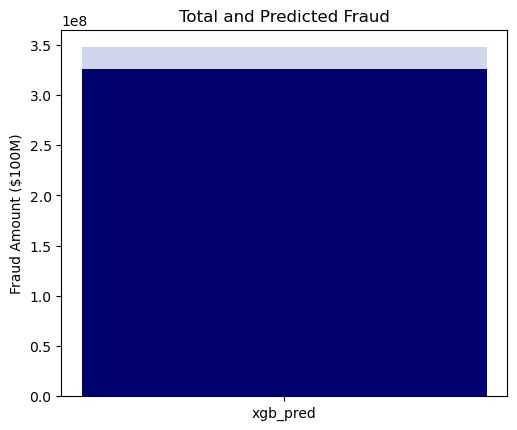

In [109]:
plot = df_monetary[df_monetary['model'] == 'xgb_pred']

plt.figure(figsize=(5.75, 4.76))
plt.title('Total and Predicted Fraud')
plt.bar(plot['model'], plot['pred_fraud'], label = 'Total Fraud', color = '#00006F')
plt.bar(plot['model'], plot['miss_fraud'], bottom = plot['pred_fraud'], label = 'Predicted Fraud', color = '#CFD5EA')

plt.ylabel('Fraud Amount ($100M)')
#plt.yticks(range)

plt.show()

In [28]:
print(f'Total fraudulent reimbursements predicted: ${test_full[(test_full['label'] == 1) & (test_full['xgb_pred'] == 1)]['tot_reimburse'].sum().sum():,}')
print(f'Total fraudulent reimbursements: ${test_full[test_full['label'] == 1]['tot_reimburse'].sum():,}')
print(f'Percentage of fraudulent reimbursements detected: {test_full[(test_full['label'] == 1) & (test_full['xgb_pred'] == 1)]['tot_reimburse'].sum()/test_full[test_full['label'] == 1]['tot_reimburse'].sum():.4f}')

Total fraudulent reimbursements predicted: $326,034,460
Total fraudulent reimbursements: $347,745,110
Percentage of fraudulent reimbursements detected: 0.9376
